In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import pandas as pd
import warnings 
# this will allow us to use the code in peace :) 
warnings.filterwarnings("ignore")

### Lecture 27:

- Take a look at data with respect to time (time series)

- Learn a bit about time series analysis. 


### Time series in Earth Science 

#### Earth's orbit - pacemaker of the Ice Ages

One of the classic problems in Earth Science is, "What controlled the coming and going of the great ice sheets?"  It has long been  known that there were several, perhaps many, ice ages. In the European Alps, several keen observationalists (among them the German author/poet/gentleman scientist, Goethe), had noticed that Alpine glaciers must have been larger in the past. 

Between 1837 and 1840, a Swiss-American geologist named Jean Louis Agassiz used the moraines, striations, and glacial erratics deposited by moving glaciers as evidence that much of Europe was once covered with a vast ice sheet like that still on Greenland today. That said, the causes of these profound climatic changes remained a mystery.  

In 1920, Milutin Milankovitz  explained the coming and going of ice ages as a response to changes in the Earth's _insolation_ (the amount of energy recieved from the sun). He argued that insolation is controlled by changes in the Earth's orbit around the sun.  This idea has now been widely embraced by the paleoclimate community, largely because of the very strong coherence between  cycles in Earth's orbit and evidence for changes in ice volume using geochemical proxies like oxygen isotopic ratios.  

The orbital cycles can be calculated by knowing the exact configuration of the planets.  Milankovitch famously took the first stab at it from his prison cell during WWI. Nowadays it is calculated with fancy computers.  The key parameters are _eccentricity_ (or ovalness of the orbit around the sun), the _obliquity_ (tilt) of the spin axis and the _precession_ of the spin axis.  

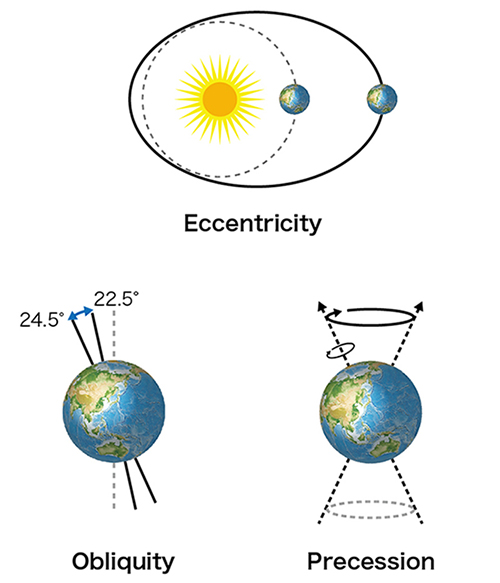

In [2]:
Image(filename='Figures/Milankovitch_Cycles.jpg')

[_Figure from_ http://www.jamstec.go.jp/e/about/press_release/20141027/; _see also_ http://www.sciencecourseware.org/eec/GlobalWarming/Tutorials/Milankovitch/].  

The Earth's orbital parameters of ellipticity, obliquity and precession vary in predictable ways.  One commonly used model for variations in them over the last few hundred million years was published by Laskar et al. (2004; http://dx.doi.org/10.1051/0004-6361:20041335).  

Let's take a look at the behavior of the last few million years using the data file from the Laskar et al. (2004) paper. 


In [3]:
# Read in the datafile into a Pandas DataFrame
cycles=pd.read_csv('Datasets/IceAges/INSOLN.LA2004.BTL.100.csv')
print (cycles.columns)

Index(['Age (ka)', 'Eccentricity', 'Obliquity', 'Precession'], dtype='object')


First, we filter the data for the last  million years and then we plot it against age, i.e., as a time series.   

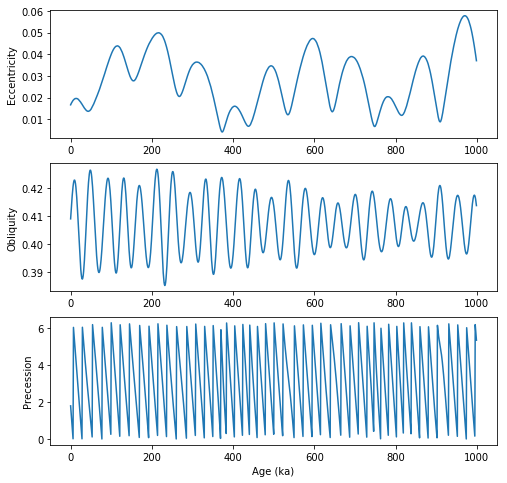

In [4]:
cycles_1Ma=cycles[cycles['Age (ka)']<1000] # only look at last 1000 ka (1 Million).   

# set up the plot as three rows
# start with Eccentricity
fig=plt.figure(1,(8,8)) # make a nice big plot
fig.add_subplot(311) # notice how you do not need the commas!
plt.plot(cycles_1Ma['Age (ka)'],cycles_1Ma['Eccentricity'])
plt.ylabel('Eccentricity')

# add obliquity
fig.add_subplot(312)
plt.plot(cycles_1Ma['Age (ka)'],cycles_1Ma['Obliquity'])
plt.ylabel('Obliquity')

# add precession
fig.add_subplot(313)
plt.plot(cycles_1Ma['Age (ka)'],cycles_1Ma['Precession'])
plt.ylabel('Precession')
plt.xlabel('Age (ka)');


You can see a lot of cycles on different time scales. The question is how this relates to the amount of insolation.  In the literature, there are many attempts to convert the orbital parameters, like those in the plot above, to the amount of insolation received by the Earth's atmosphere as a function of latitude and age.  One recent paper was by Huybers (Huybers, P. 2006, http://dx.doi.org/10.1126/science.1125249).   You can get the data (credited to Huybers and our own Professor Ian Eisenman)
from here: https://www.ncdc.noaa.gov/paleo-search/study/5792.  

It is traditional to consider the amount of insolation received at 65$^{\circ}$N.  So let's take a look.

Index(['Age (ka)', 'Insolation (W/m^2)'], dtype='object')


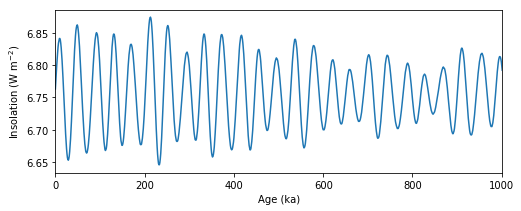

In [5]:
#read the data into a pandas DataFrame
fig=plt.figure(2,(8,3))
insol=pd.read_csv('Datasets/IceAges/j_65north.csv')
print (insol.columns)
plt.plot(insol['Age (ka)'],insol['Insolation (W/m^2)'])
plt.xlim(0,1000)
plt.ylabel('Insolation (W m$^{-2}$)')
plt.xlabel('Age (ka)');

But how do we relate these wiggles to ice ages?  Glaciers tend to over-ride the evidence of their older siblings (as we saw in the lecture on rose diagrams), so how do we know the timing and extent of past glaciations?  The answer is marine fossils. Marine fossils, for example, formainifera, are made of calcium carbonate and retain a record of the oxygen isotopic ratios of the sea water in which they live.  And "So?", you say.  What does that have to do with ice volume?   Here is the answer in a nutshell: 
- There are several isotopes of oxygen, two of which are fairly common: $^{18}$O and $^{16}$O.  
- During evaporation, the lighter isotope is preferentially removed, leaving the water body enriched in the heavier isotope.  When the water condenses, the process is reversed and the heavier isotope is preferentially removed. So nothing should happen over time, right?  What goes up must come down.  But it isn't that simple.  
- Evaporation occurs mostly in the tropics (because it is hotter)   and then the clouds move north raining and snowing out as they go. This process is Rayleigh distillation and results in an enrichment of the light oxygen isotopes in the rain and snow.  If the snow gets trapped on land, for example in a glacier or ice sheet, then there is  an enrichment of the heavier isotope in the sea water. The ratio of the two isotopes is a proxy of the volume of ice.  

We will need a measure of the isotopic ratios in foraminifera recovered from deep sea sediment cores and their DATES. The latter was done using magnetic stratigraphy (see, e.g., Shackleton and Opdyke, 1973, Quaternary Research, 3, 39-55, https://doi.org/10.1016/0033-5894(73)90052-5).  \[Magnetic stratigraphy uses records of reversals of the magnetic field recorded in sequences of rocks to date them.\]  

A modern version of these data was published by Lisecki and Raymo (2005, http://dx.doi.org/10.1029/2004PA001071) called the LR04 stack.  This is   a stack of 58 records of oxygen isotopic variations, several of which were independently dated using magnetostratigraphy, from all over the world's oceans.   



Let's take a look at that record: 

In [6]:
d18O=pd.read_csv('Datasets/IceAges/LR04stack.csv')
print (d18O.columns)

Index(['Age (ka)', 'd18O', 'uncertainty'], dtype='object')


The data are cast as $\delta ^{18}O$, defined as: 


$$\delta ^{{18}}O={\Biggl (}{\frac  {{\bigl (}{\frac  {^{{18}}O}{^{{16}}O}}{\bigr )}_{{sample}}}{{\bigl (}{\frac  {^{{18}}O}{^{{16}}O}}{\bigr )}_{{standard}}}}-1{\Biggr )}\times 1000\ ^{{o}}\!/\!_{{oo}}$$

And it is traditional to plot them with the heavier isotope down.  

Let's plot them up for the last million years. 




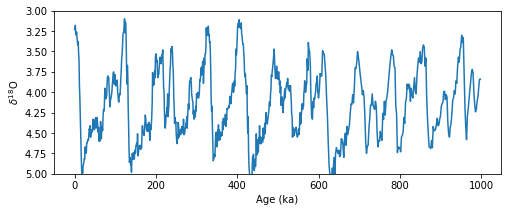

In [7]:
fig=plt.figure(3,(8,3))
d18O_1Ma=d18O[d18O['Age (ka)']<1000] # filter data for last 1Ma
plt.plot(d18O_1Ma['Age (ka)'],d18O_1Ma['d18O'])
plt.xlabel('Age (ka)')
plt.ylabel('$\delta ^{18}$O')
plt.ylim(5,3);

Both insolation and $\delta ^{18}$O have a lot of wiggles over the last million years, but are they the SAME wiggles?  One way to look at this is using _time series analysis_.   There are entire courses devoted to this subject and a complete treatment is WAY beyond the scope of this class, but we can begin to answer the basic question posed by the isotope/insolation story.  The big question is:  Do the two data sets have wiggles with the same frequencies?  

The analysis boils down to this: 

- According to Fourier, any periodic function $f(t)$ can be represented as the sum of a series of sines and cosines:   

$$f(t)=a_0+ \sum_{r=1}^\infty \bigr[a_r    \cos  \bigr( { {2\pi r}\over{T}}   t\bigr)  + b_r    \sin  \bigr( { {2\pi r}\over{T}}   t\bigl) \bigl]  $$

- You can represent data as a series in time (in the time-domain) as we have been doing OR you can represent the data in terms of frequency, looking for the _power_ in the data as a function of frequency.  This is known as the _power spectrum_. 


Let's do a zero order analysis that produces a _periodogram_, which is a plot of power versus frequency. We will do this with the minimum of massaging.


Let us take advantage of a **signal.periodogram** function in the **scipy** package.  That module has functions that allow us to  calculate the _power spectral density_ for a time series.  

Also, we know that eccentricity is supposed to have a dominant period at 100 kyr, obliquity at 41 kyr and precession at 23 and 19 kyr. Remember that these numbers are expressed in terms of  the period, which is the inverse of the frequency. 

We can see how our minimalist treatment works.  

Let's start with precession:



In [8]:
# first we import the necessary function:
from scipy import signal 

help(signal.periodogram)


Help on function periodogram in module scipy.signal.spectral:

periodogram(x, fs=1.0, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
    Estimate power spectral density using a periodogram.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length must be nperseg. Defaults
        to 'boxcar'.
    nfft : int, optional
        Length of the FFT used. If `None` the length of `x` will be
        used.
    detrend : str or function or `

We can call the function, which returns frequencies and power. 


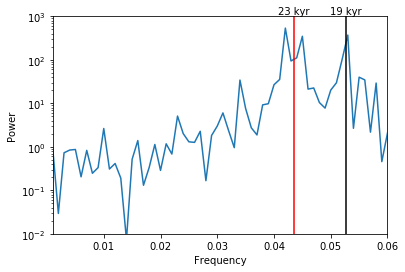

In [9]:
# make an array out of the desired data series
prec=np.array(cycles_1Ma['Precession'])

# and calculate the frequencies 
prec_freqs,prec_power=signal.periodogram(prec)
# plot on a linear x, log y plot (using semilogy( ))
plt.semilogy(prec_freqs,prec_power)
plt.ylim(.01,1000) # truncate the Y axis
plt.xlim(.001,.06) # truncate the X axis
# put on the precessional frequencies
plt.axvline(x=1./23.,color='red')  # use a vertical line
plt.axvline(x=1./19.,color='black')
plt.xlabel('Frequency') # label the axes
plt.ylabel('Power')
plt.text(1./23.,1000,'23 kyr',ha='center',va='bottom')
plt.text(1./19.,1000,'19 kyr',ha='center',va='bottom');




It is a little rough but you can clearly see the two peaks near 23 and 19 kyr. We could smooth out the diagram by exploring _windowing_ options, but for now, let us just plow on, looking at obliquity next.  



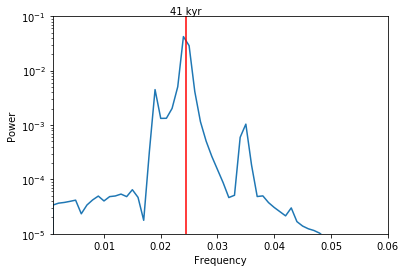

In [10]:
# make an array out of the desired data series
obl=np.array(cycles_1Ma['Obliquity'])

# and calculate the frequencies 
obl_freqs,obl_power=signal.periodogram(obl)

plt.semilogy(obl_freqs,obl_power)
plt.ylim(.00001,.1)
plt.xlim(.001,.06)
# put on the obliquity frequencies
plt.axvline(x=1./41.,color='red') 
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.text(1./41.,.1,'41 kyr',ha='center',va='bottom');


Note the strong obliquity (41 kyr) signal.

### Are there orbital frequencies in the isotopic data? 

At last we can look at our isotope time series and see if the same frequencies are there.  If so, that would support Milankovitch's famous hypothesis regarding orbits and ice ages.  

We will also throw in an example of a _window_ in the periodogram calculation.  What a _window_ does is multiply the time series by a function (called a taper) that weights information, suppressing data at the edges of the window and focussing on the center of the window.  The simplest window is a _box car_ which gives equal weight to everything inside the window.  In the following, we will use a _Blackman window_ which looks more like a bell curve.   

You can find out more about windowing (a.k.a. tapering) from this website:  

https://en.wikipedia.org/wiki/Window_function

Let's take a look at the LR04 data set. 


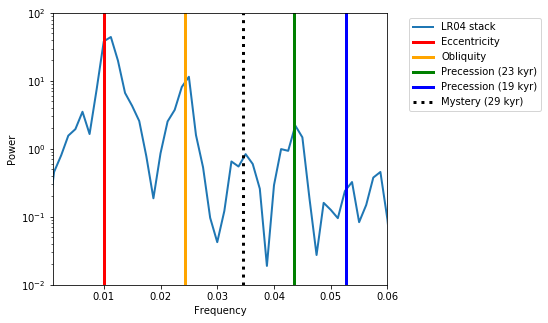

In [11]:
plt.figure(4,(6,5))
iso=d18O_1Ma['d18O'] # pick out the data series
# set the window with the keyword 'window'
iso_freqs,iso_power=signal.periodogram(iso,window='blackman')
plt.semilogy(iso_freqs,iso_power,label='LR04 stack',linewidth=2)
plt.ylim(.01,100) # put bounds on the axes
plt.xlim(.001,.06)
plt.axvline(x=1./100.,color='red',label='Eccentricity',linewidth=3) 
plt.axvline(x=1./41.,color='orange',label='Obliquity',linewidth=3) 
plt.axvline(x=1./23.,color='green',label='Precession (23 kyr)',linewidth=3) 
plt.axvline(x=1./19.,color='blue',label='Precession (19 kyr)',linewidth=3)
plt.axvline(x=1./29.,color='black',label='Mystery (29 kyr)',linewidth=3,linestyle='dotted')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2) # notice this
# way of putting the legend to the right of the plot


plt.xlabel('Frequency')
plt.ylabel('Power'); 

And... of course there is lots of power in the Milankovitch periods. But there is an extra 'hump' at 29 kyr which Lisecki and Raymo say is, "commonly observed and is thought to be a nonlinear climate response", citing a paper by Huybers and Wunsch (2004).  Hmmm. Room for more research. 

Of course there are still many questions on this subject, like "How do the orbital parameters control the ice volume?" and, "Why aren't we heading into an ice age now?" as Milankovitch theory would predict.  

### For more on time series analysis in Earth Science:
What is covered in this lecture is just a conceptual start.  There are no uncertainty estimates, for example.  To get realistic uncertainties, it is necessary to subsample the data with different windows that use independent subsets, a technique known as the _multi-taper spectral estimation_. One excellent reference for that is: 

Prieto, G. A., R. L. Parker, F. L. Vernon. (2009),
A Fortran 90 library for multitaper spectrum analysis,
Computers and Geosciences, 35, pp. 1701-1710.
doi:10.1016/j.cageo.2008.06.007 

There is obviously much more to learn about time series that is beyond what we can do here (mostly having to do how you massage the data).  If you are curious, there are some very nice Python wrappers for beautiful code for doing cool state-of-the-art time series analysis (see, e.g., http://krischer.github.io/mtspec/ for how to install the code and examples of how to use it. Let me know if you want help doing this, for example for a final project.)  It works very well on Linux and MacOS systems and gives you time series power spectra with error bars! 


But first,  you have to install some stuff (if it isn't already installed):

on the command line on a Mac:  

- pip install mtspec

- brew install gcc

for help, see http://krischer.github.io/mtspec/


Here is an example of how it works: 

Then you read in the data and analyze it: 

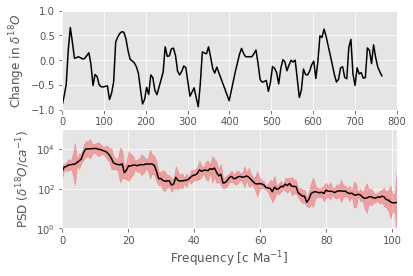

In [12]:
from mtspec import mtspec
from mtspec.util import _load_mtdata
plt.style.use("ggplot")


data = _load_mtdata('v22_174_series.dat.gz')

# Calculate the spectral estimation.
spec, freq, jackknife, _, _ = mtspec(
    data=data, delta=4930.0, time_bandwidth=3.5,
    number_of_tapers=5, nfft=312, statistics=True)

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
# Plot in thousands of years.
ax1.plot(np.arange(len(data)) * 4.930, data, color='black')
ax1.set_xlim(0, 800)
ax1.set_ylim(-1.0, 1.0)
ax1.set_xlabel("Time [1000 years]")
ax1.set_ylabel("Change in $\delta^{18}O$")

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_yscale('log')
# Convert frequency to Ma.
freq *= 1E6
ax2.plot(freq, spec, color='black')
ax2.fill_between(freq, jackknife[:, 0], jackknife[:, 1],
                 color="red", alpha=0.3)
ax2.set_xlim(freq[0], freq[-1])
ax2.set_ylim(0.1E1, 1E5)
ax2.set_xlabel("Frequency [c Ma$^{-1}]$")
ax2.set_ylabel("PSD ($\delta^{18}O/ca^{-1}$)");





Cool, no?

 Until now, we have been looking at only the last million years of the LR04 five million year series.  That is because our approach to time series requires that the series be stable (not change through time).  If we look at the whole series, you can see that that assumption is not true and the spectral character changes over time: 





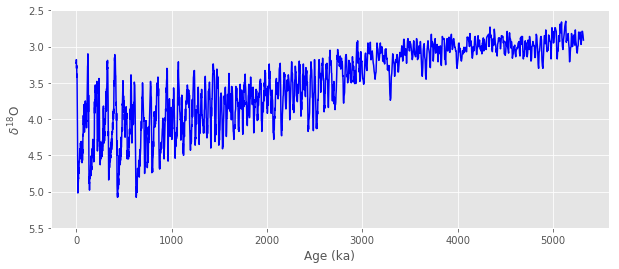

In [13]:
d18O=pd.read_csv('Datasets/IceAges/LR04stack.csv')
fig=plt.figure(3,(10,4))
plt.plot(d18O['Age (ka)'],d18O['d18O'],'b-')
plt.xlabel('Age (ka)')
plt.ylabel('$\delta ^{18}$O')
plt.ylim(5.5,2.5);

Before about 2700 ka, the variation is small and since 1000 ka, the variation is much greater and dominated by the 100 kyr (eccentricity) cycle as we learned above.  

So, how do we deal with changing spectral character?  To handle this exact prblem, there is a different way of looking at time series that is quite popular now - wavelets.  There is a nice reference that uses wavelets on the LR04 dataset (Mukhin et al., 2019, available at: https://www.nature.com/articles/s41598-019-43867-3).  
But wavelets, while pretty, are a confusing and the theory is challenging (see this tutorial):
 https://towardsdatascience.com/what-is-wavelet-and-how-we-use-it-for-data-science-d19427699cef

Nonetheless it is a powerful way of looking at time series that change through time (like LR04). 

Here is what we have to do:

1) detrend the data to remove the linear trend in the data.  We can do that with the **scipy.signal.detrend( )** funtion. 
2) apply the wavelet transform which is a window that moves through the time series.  Here the devil is in the details and there are many windows possible (e.g., Morlet, Ricker - aka 'Mexican Hat', and so on).  The Mukhin et al. analysis used the Morlet window and that seems to be the most common window. It is also the default in the Aaron O'Leary "Wavelets" Python module (described here: doi:10.21105/joss.01237).  This package can be installed with the command: pip install git+https://github.com/aaren/wavelets   
3) Plot the data.  Here we are already equipped because we are familiar with **matplotlib**'s **contourf( )** function!  

So here goes.  

In [14]:
# iport the required packages
import scipy.signal as signal
from wavelets import WaveletAnalysis


Text(0.5,0,'Age (kyr)')

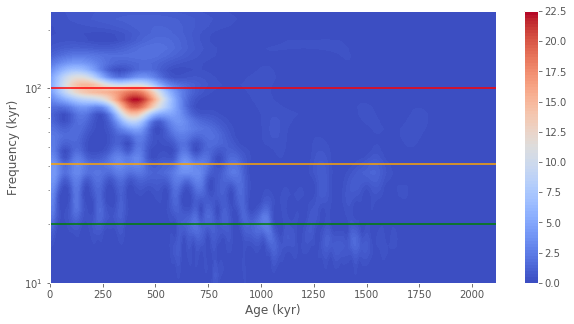

In [17]:
# read in the data again:
d18O=pd.read_csv('Datasets/IceAges/LR04stack.csv')
# detrend the data
d18O_detrend=signal.detrend(d18O['d18O'].values)

# delta t is the spacing of the data, which here are 1 kyr, so set dt to 1
dt = 1

# perform the data analysis with WaveletAnalysis

wa = WaveletAnalysis(d18O_detrend, dt=dt)

# wavelet power spectrum
power = wa.wavelet_power

# scales 
scales = wa.scales

# associated time vector
t = wa.time

# reconstruction of the original data
rx = wa.reconstruction()

# plot the data

fig, ax = plt.subplots(figsize=(10,5))
T, S = np.meshgrid(t, scales)
m=ax.contourf(T, S, power, 100,cmap='coolwarm')
cbar=plt.colorbar(m,orientation='vertical') 
# put on a color bar of intensities
plt.axhline(y=100.,color='red',label='Eccentricity') 
plt.axhline(y=41.,color='orange',label='Obliquity') 
plt.axhline(y=20.,color='green',label='Precession (23 kyr)') 


ax.set_yscale('log')
ax.set_ylim(10,250)
ax.set_ylabel ('Frequency (kyr)')
ax.set_xlabel ('Age (kyr)')



So what do we see?  I put on the 100 kyr (red), 40 kyr (orange) and 20 kyr (green) horizontal lines to show you the eccentricity, obliquity and precessional frequencies.  Age is along the x axis.   You can see immediately that there is a big fat band of red (high power) at about 100 kyr, but only for the last ~600 kyr.  In that same  interval, you can also see a strong 40 kyr and perhaps weaker 20 kyr signal.  Before that time to about 1000 kyr, the 100 kyr signal is not really there, but the 40 and 20 kyr frequencies are strong.  But prior to that until about 1250 kyr, there is an interval with strong 20 kyr but weak 40 kyr.  in the earlier times (back to about 1600 kyr) the 40 kyr signal is stronger.  So, clearly the climate changes a LOT throughout the Pleistocene and the causes are of course the subject of much debate.  